In [1]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd
import time
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 2

In [3]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [4]:
#-------------------------------------------
#Choose the Model you want!
# from Model_alphaWGAN import *
# from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
from Model_VAEGAN import Generator
from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
E = Encoder(out_class = latent_dim).cuda(gpu)
# E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./wl_checkpoint_2/G_iter67500.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./wl_checkpoint_noBN/G_iter75500.pth')) #VAE-GAN
G.load_state_dict(torch.load('./vae_checkpoint/G_VG_ep_299.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


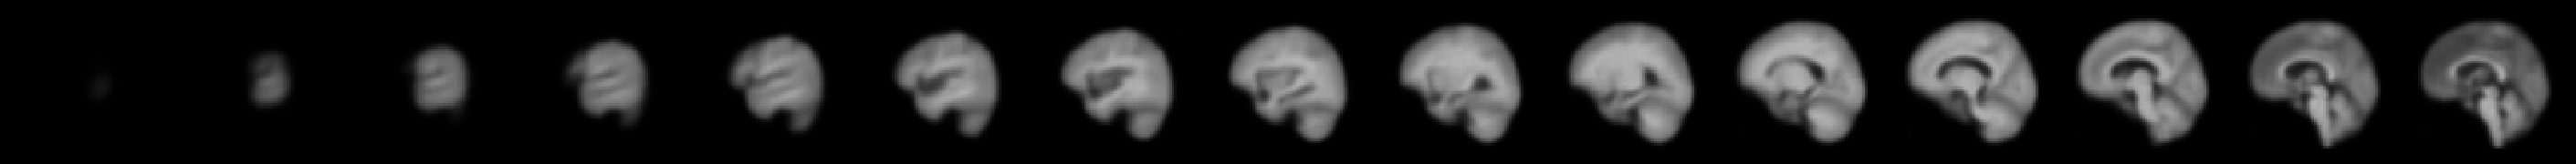

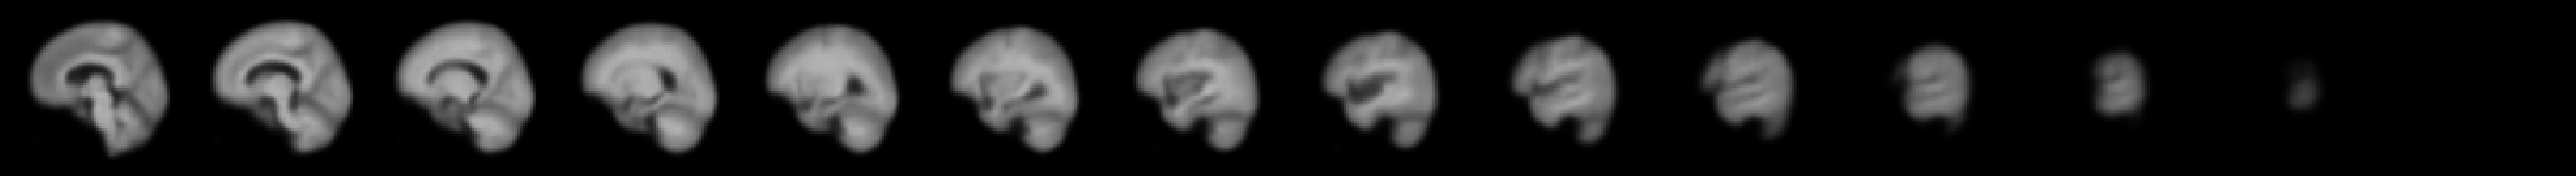

In [6]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

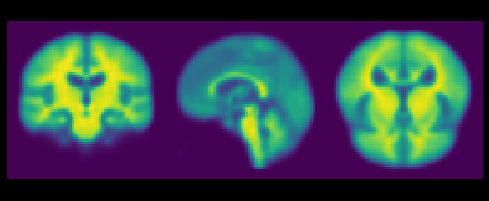

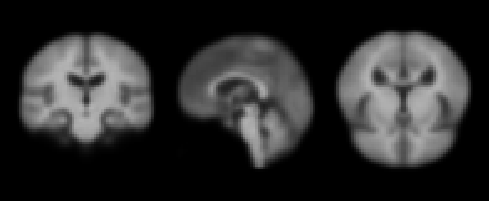

In [7]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

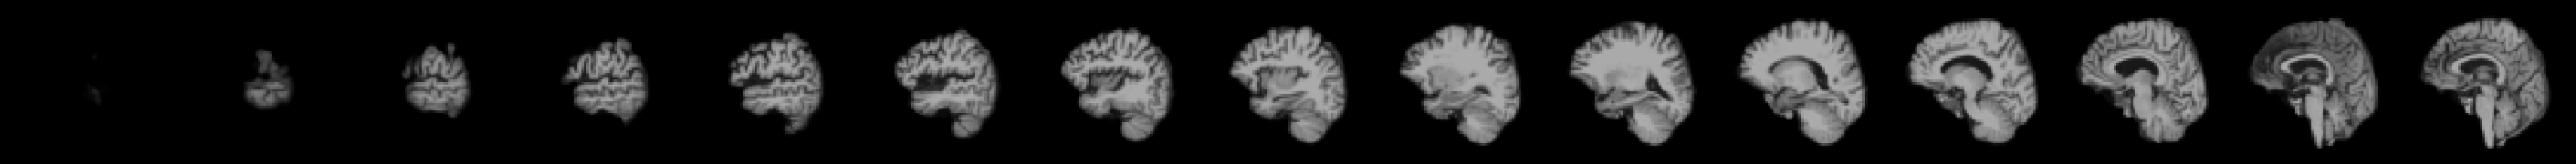

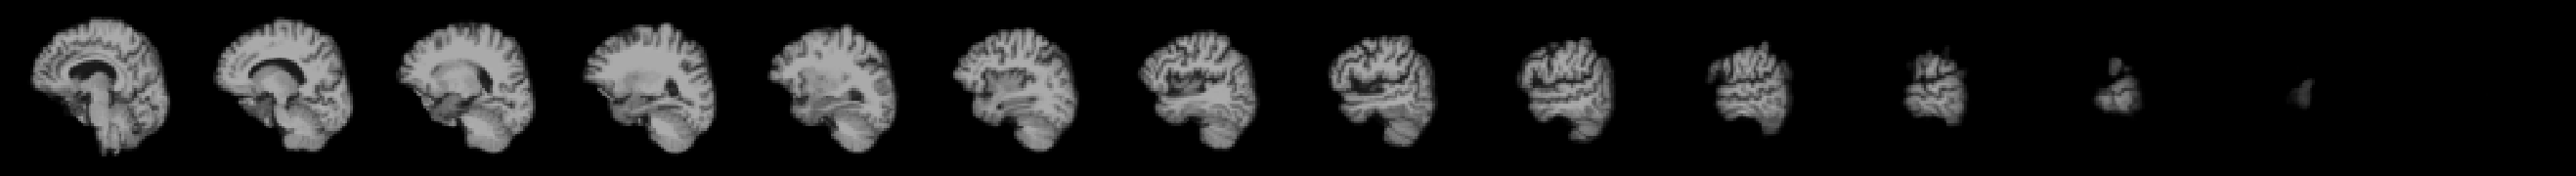

In [8]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# FID test on train-test split

In [11]:
real_data = np.ones((100, 2))
real_data[:50, 0] = 2
gen_data = np.ones((100, 2)) * 9
gen_data[50:, 0] = 2
calculate_fid(real_data, gen_data, cuda_ind=gpu)

array(89.09090909)

In [11]:
train_set, test_set = torch.utils.data.random_split(trainset, [int(len(trainset)/2), len(trainset)-int(len(trainset)/2)])
train_loader, test_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=workers),torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=workers)
train_loader, test_loader = inf_train_gen(train_loader), inf_train_gen(test_loader)
total = 0 
for i in range(10):
    start = time()
    x, y = train_loader.__next__(), test_loader.__next__()
    x, y = x.reshape(64, -1), y.reshape(64, -1)
    score = calculate_fid(np.array(x), np.array(y))
    total += score
    print(score, f'time spent {time()-start}')
print('total', total/10)


CUDARuntimeError: cudaErrorIllegalAddress: an illegal memory access was encountered

# FID test on model

In [9]:
path = 'vae_checkpoint'
total = 0
# G.load_state_dict(torch.load(f'./{path}/G_iter200000.pth'))
G.load_state_dict(torch.load(f'./{path}/G_VG_ep_100.pth'))
for i in range(10):
    start = time()
    image = gen_load.__next__()[0]
    z_r = Variable(torch.randn((1, 1000)).cuda(gpu), requires_grad=True)
    x_r = G(z_r)
    image, x_r = image.reshape(64, -1), x_r.reshape(64, -1)
    score = calculate_fid(image.cpu().detach(), x_r.cpu().detach())
    total += score
    print(score, f'time spent {time()-start}')
print('total', total/10)


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [10]:
%debug

> /projects/shibo/3dbraingen/cupy/core/_kernel.pyx(104)cupy.core._kernel._preprocess_args()

ipdb> u
> /projects/shibo/3dbraingen/cupy/core/_kernel.pyx(1041)cupy.core._kernel.ufunc.__call__()

ipdb> u
> /projects/shibo/3dbraingen/cupy/core/core.pyx(1021)cupy.core.core.ndarray.__sub__()

ipdb> u
> /projects/shibo/3dbraingen/utils/__init__.py(46)calculate_fid()
     44             covmean = covmean.real
     45         # calculate score
---> 46         fid = ssdiff + cp.trace(sigma1 + sigma2 - 2.0 * covmean)
     47         return fid
     48 

ipdb> type(covmean)
<class 'numpy.ndarray'>
ipdb> type(sigma1)
<class 'cupy.core.core.ndarray'>
ipdb> exit


# MS-SSIM Calculation

In [13]:
G.load_state_dict(torch.load('./mmd_checkpoint/G_iter42000.pth'))
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda(gpu))
    images = gen_load.__next__().cuda(gpu)
#   images = G(noise)
    img1 = images[0]
    img2 = images[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(f'final ssim: {sum_ssim/1000}')

FileNotFoundError: [Errno 2] No such file or directory: './mmd_checkpoint/G_iter42000.pth'

# MS-SSIM for real images

In [6]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)

i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

100 tensor(0.0856)
200 tensor(0.1699)
300 tensor(0.2558)
400 tensor(0.3398)
500 tensor(0.4250)
600 tensor(0.5105)
700 tensor(0.5953)
800 tensor(0.6800)
900 tensor(0.7654)
tensor(0.8399)


# Maximum-Mean Discrepancy Score

### calculate averaged mmd score

In [9]:
# try different variances for z_e
# var = [0.1, 1, 2, 5, 10, 20, 30, 50, 100]
# for i in range(len(var)-1, -1, -1):
# for i in range(162500, 200000, 2000):
#     G.load_state_dict(torch.load(f'./checkpoint/G_iter{i}.pth'))
#     calc_mmd(train_loader, G, i, gpu_ind=gpu, path='test_data')
# G.load_state_dict(torch.load(f'./vae_checkpoint_1/G_VG_ep_100.pth'))
mmd_pth = 'wl_checkpoint_2'
for i in range(200000, -1, -20000)[1:]:
    print(f'testing iteration {i}')
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
    calc_mmd(train_loader, G, 0, count=100, gpu_ind=gpu, path='test_data_1', no_write=False)

testing iteration 180000


RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "tp_conv1.weight". 

### create mmd cruve

In [ ]:
mmd_pth = 'vae_checkpoint_1'
last_ind = int(read_mmd(mmd_pth)) + 1
for i in range(last_ind, 300, 1):
# for i in range(last_ind+1000, 200001, 1000):
# for i in range(1000, 200001, 1000):
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
#     E.load_state_dict(torch.load(f'./mmd_checkpoint/E_iter{i}.pth'))
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, path=mmd_pth, no_write=False)

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



iteration: 181, count: 0, Mean: 369.3712197580645, cost 52.88399887084961 seconds

iteration: 181, count: 1, Mean: 374.39390120967744, cost 54.34994959831238 seconds

iteration: 181, count: 2, Mean: 359.1290322580645, cost 49.90232300758362 seconds

iteration: 181, count: 3, Mean: 375.20211693548384, cost 48.65961194038391 seconds

iteration: 181, count: 4, Mean: 377.98613911290323, cost 48.953718423843384 seconds

iteration: 181, count: 5, Mean: 348.10332661290323, cost 48.97602653503418 seconds

iteration: 181, count: 6, Mean: 356.12953629032256, cost 49.87655162811279 seconds

iteration: 181, count: 7, Mean: 360.4881552419355, cost 49.72755980491638 seconds

iteration: 181, count: 8, Mean: 351.0030241935484, cost 49.67050766944885 seconds


### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### alpha gan Images PCA Visualization

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)


index: 1000, sample_mean: -0.8268733024597168 sample_var: 0.037541233003139496, yellow_mean: -0.8593521118164062 yellow_var: 0.05592358484864235


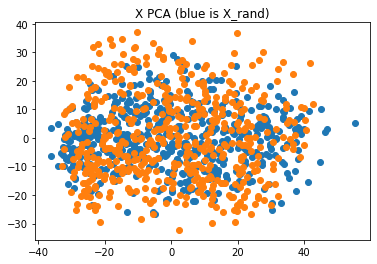

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 2000, sample_mean: -0.7929945588111877 sample_var: 0.04887407645583153, yellow_mean: -0.8587020635604858 yellow_var: 0.05646432936191559


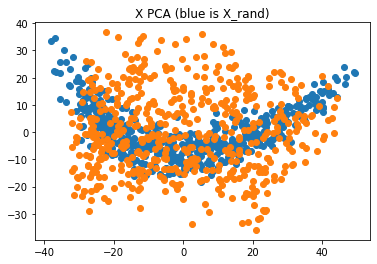

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 3000, sample_mean: -0.7823725938796997 sample_var: 0.039151858538389206, yellow_mean: -0.8581933975219727 yellow_var: 0.056912366300821304


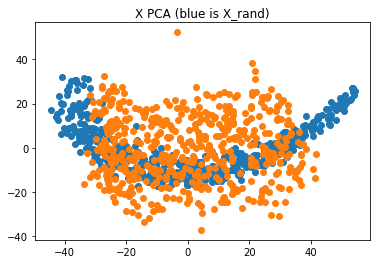

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 4000, sample_mean: -0.7999359369277954 sample_var: 0.03425954282283783, yellow_mean: -0.8588423728942871 yellow_var: 0.05641265586018562


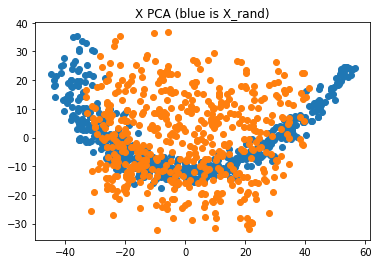

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 5000, sample_mean: -0.8306851387023926 sample_var: 0.02991306409239769, yellow_mean: -0.8599317073822021 yellow_var: 0.055668458342552185


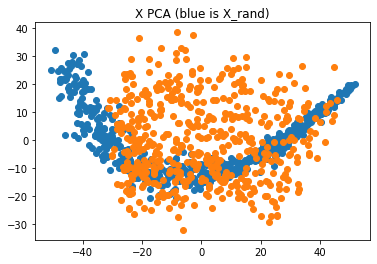

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 6000, sample_mean: -0.8820444345474243 sample_var: 0.024391932412981987, yellow_mean: -0.8597780466079712 yellow_var: 0.05564403533935547


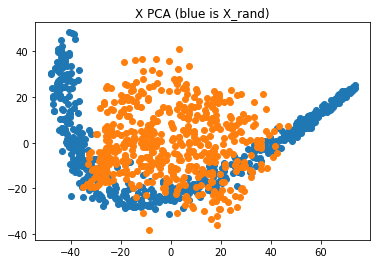

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 7000, sample_mean: -0.8758535981178284 sample_var: 0.024385850876569748, yellow_mean: -0.8597164154052734 yellow_var: 0.055746931582689285


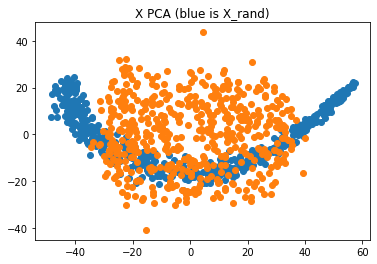

/projects/shibo/3dbraingen/utils/__init__.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(images, requires_grad=False)
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 8000, sample_mean: -0.8832826614379883 sample_var: 0.023278191685676575, yellow_mean: -0.8594119548797607 yellow_var: 0.05581313371658325


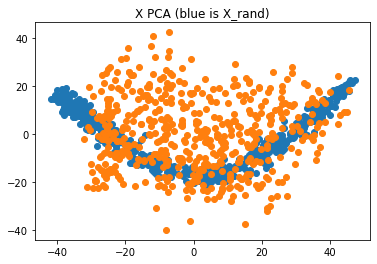

FileNotFoundError: [Errno 2] No such file or directory: './vae_checkpoint_gp/G_iter9000.pth'

In [23]:
for i in range(1000, 100000, 1000):
# for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./vae_checkpoint_gp/G_iter{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

### vaegan Images PCA Visualization

In [ ]:
for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./vae_checkpoint/E_VG_ep_{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

In [29]:
loss_df = load_loss(path='./wl_checkpoint_2/loss.csv')
# print(loss_df)
# alpha_wgan
loss_df[['d_fake', 'd_real_loss', 'd_recon', 'err_enc']].plot() 
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()
plt.figure(figsize=(400, 400))
loss_df.plot()

KeyError: "None of [Index(['d_fake', 'd_real_loss', 'd_recon', 'err_enc'], dtype='object')] are in the [columns]"

### latent vector pca

In [ ]:
E.load_state_dict(torch.load(f'./checkpoint/E_iter33500.pth'))
viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True)

<Figure size 432x288 with 0 Axes>

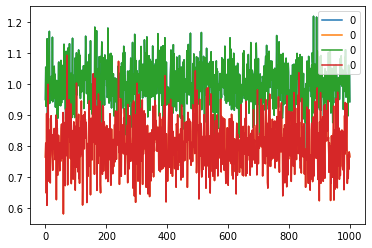

index: 100, sample_mean: 0.006653747987002134 sample_var: 0.8789551258087158, yellow_mean: 0.00048705609515309334 yellow_var: 1.0029163360595703


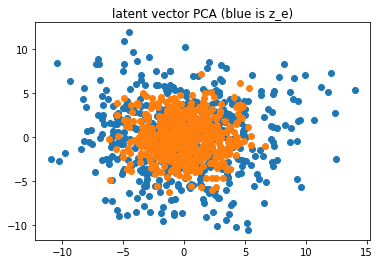

<Figure size 432x288 with 0 Axes>

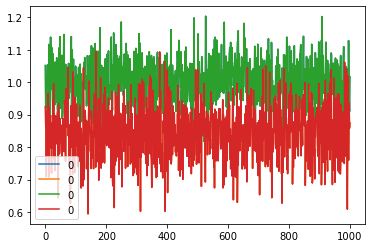

index: 90, sample_mean: -0.0014567391481250525 sample_var: 0.901488184928894, yellow_mean: 0.0008254039566963911 yellow_var: 1.0006296634674072


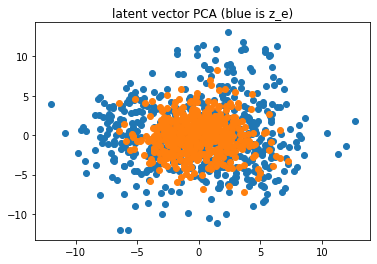

<Figure size 432x288 with 0 Axes>

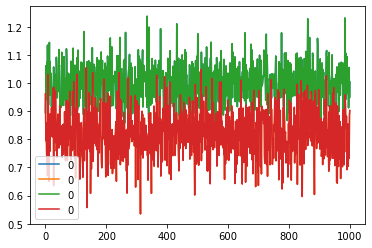

index: 80, sample_mean: 0.003673180937767029 sample_var: 0.8817150592803955, yellow_mean: 0.0005380789516493678 yellow_var: 1.0000969171524048


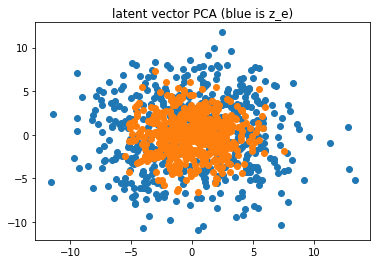

KeyboardInterrupt: 

In [32]:
# for VAEGAN
for i in range(100, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=1)

<Figure size 432x288 with 0 Axes>

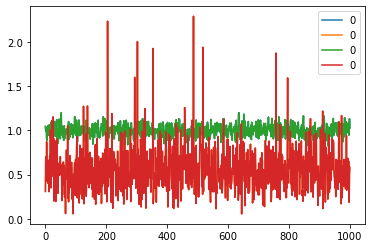

index: 42000, sample_mean: 0.40957510471343994 sample_var: 1.0267934799194336, yellow_mean: 0.000111085653770715 yellow_var: 0.9984131455421448


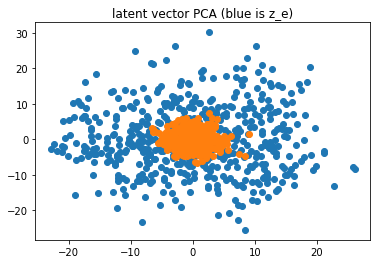

<Figure size 432x288 with 0 Axes>

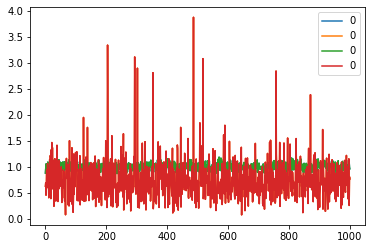

index: 40000, sample_mean: -0.3916565775871277 sample_var: 1.2726112604141235, yellow_mean: -0.001360844704322517 yellow_var: 1.001855492591858


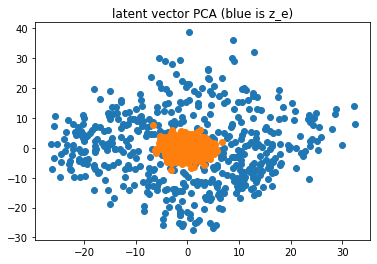

<Figure size 432x288 with 0 Axes>

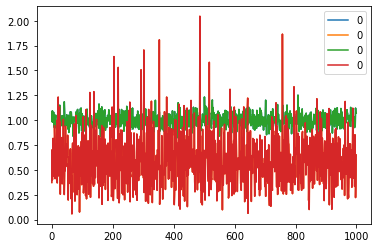

index: 38000, sample_mean: 0.17769847810268402 sample_var: 1.0876328945159912, yellow_mean: -0.0021576026920229197 yellow_var: 1.0004405975341797


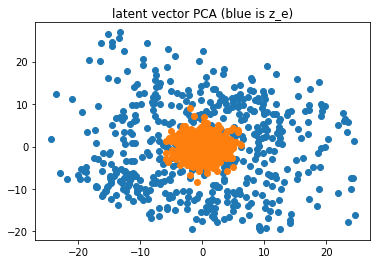

<Figure size 432x288 with 0 Axes>

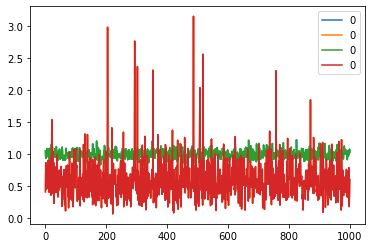

index: 36000, sample_mean: 0.02729233168065548 sample_var: 1.0989036560058594, yellow_mean: -0.0004963766550645232 yellow_var: 1.0006849765777588


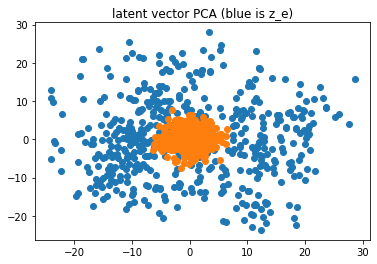

<Figure size 432x288 with 0 Axes>

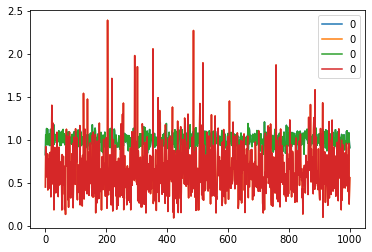

index: 34000, sample_mean: 0.2928736209869385 sample_var: 1.1873912811279297, yellow_mean: -0.002154085086658597 yellow_var: 0.9987492561340332


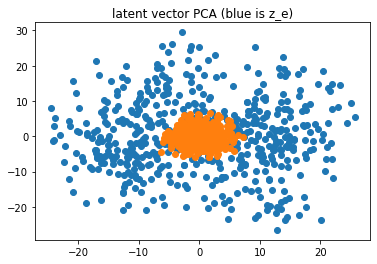

<Figure size 432x288 with 0 Axes>

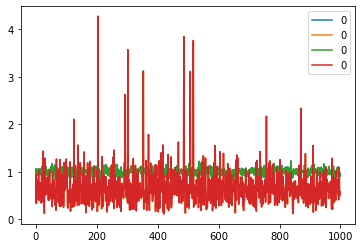

index: 32000, sample_mean: 0.18021085858345032 sample_var: 1.3287127017974854, yellow_mean: 0.0010842203628271818 yellow_var: 0.9992814064025879


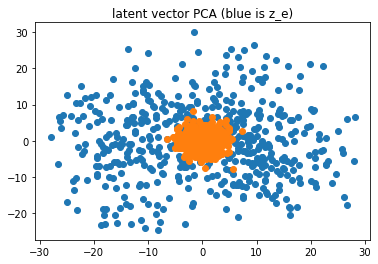

<Figure size 432x288 with 0 Axes>

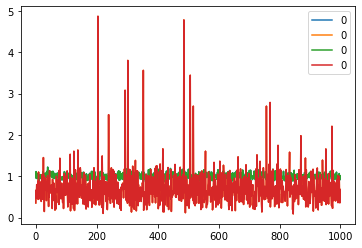

index: 30000, sample_mean: -0.3683076798915863 sample_var: 1.1792489290237427, yellow_mean: -0.00010218736133538187 yellow_var: 1.0017927885055542


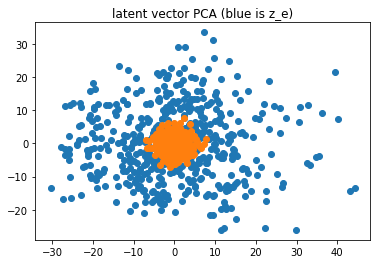

KeyboardInterrupt: 

In [18]:
# for AlphaWGAN
for i in range(42000, 0, -2000):
    E.load_state_dict(torch.load(f'./wl_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

### delete CD and D

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
